# House price prediction using linear regression (minimal)

In [ ]:
# Imports
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
# Hyperparameters
batch_size=64
learning_rate=5e-7


# Other constants
DATASET_URL = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
DATA_FILENAME = "BostonHousing.csv"
TARGET_COLUMN = 'medv'
input_size=13
output_size=1

## Dataset & DataLoaders

In [ ]:
# Download the data
download_url(DATASET_URL, '.')
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [ ]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop('medv', axis=1).values
targets = dataframe[['medv']].values

print('inputs.shape: ', inputs.shape,'\ntargets.shape: ', targets.shape)

inputs.shape:  (506, 13) 
targets.shape:  (506, 1)


In [ ]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32),
                        torch.tensor(targets, dtype=torch.float32)
                       )

train_ds, val_ds = random_split(dataset, [406, 100])

train_loader = DataLoader(train_ds, 
                          batch_size, 
                          shuffle=True
                         )

val_loader = DataLoader(val_ds, 
                        batch_size*2
                       )

## Model

In [ ]:
class HousingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
    
model = HousingModel()

## Training

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
result = evaluate(model, val_loader)
result

{'val_loss': 5888.53759765625}

In [ ]:
history = fit(10, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 1275.0210
Epoch [1], val_loss: 981.0937
Epoch [2], val_loss: 749.2508
Epoch [3], val_loss: 591.7235
Epoch [4], val_loss: 490.6913
Epoch [5], val_loss: 386.2016
Epoch [6], val_loss: 325.3594
Epoch [7], val_loss: 283.0609
Epoch [8], val_loss: 253.1290
Epoch [9], val_loss: 233.4693


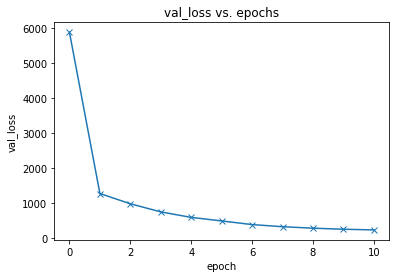

In [ ]:
losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

## Predictions

In [ ]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [ ]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([6.9110e-02, 4.5000e+01, 3.4400e+00, 0.0000e+00, 4.3700e-01, 6.7390e+00,
        3.0800e+01, 6.4798e+00, 5.0000e+00, 3.9800e+02, 1.5200e+01, 3.8971e+02,
        4.6900e+00])
Target:  30.5
Prediction: 1.5883392095565796


# THE END